In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gc
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/amexfeather/test_data_f32.ftr
/kaggle/input/amexfeather/train_data.ftr
/kaggle/input/amexfeather/train_data_f32.ftr
/kaggle/input/amexfeather/test_data.ftr
/kaggle/input/amex-default-prediction/sample_submission.csv
/kaggle/input/amex-default-prediction/train_data.csv
/kaggle/input/amex-default-prediction/test_data.csv
/kaggle/input/amex-default-prediction/train_labels.csv


# Create custom estimator classes and transformer classes

In [2]:
class ColumnDrop(BaseEstimator, TransformerMixin):
    def __init__(self,notnull_threshold=0.5,columns_to_drop=None):
        self.columns_to_drop = columns_to_drop
        self.notnull_threshold = notnull_threshold
    
    def fit(self, X, y=None):
        null_counts = X.isnull().sum()
        null_percent = pd.concat([null_counts,null_counts/len(train_dataset)],axis=1)
        null_percent.columns=['count','percentage']
        self.columns_to_drop = null_percent.loc[null_percent.percentage > self.notnull_threshold].index
        self.columns_to_drop = list(self.columns_to_drop)
        
        return self
    
    def transform(self, X):
        X = X.drop(self.columns_to_drop,axis=1)
        
        return X

In [3]:
train_dataset_ = pd.read_feather('../input/amexfeather/train_data.ftr')
# Keep the latest statement features for each customer
train_dataset = train_dataset_.groupby('customer_ID').tail(1).set_index('customer_ID', drop=True).sort_index()

The dataset of this competition has a huge size. If you're reading raw CSV files, It will create a out of memory error. That's why we read the data from AMEX-Feather-Dataset.

In [4]:
del train_dataset_
gc.collect()

23

In [5]:
train_dataset.head()

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,2018-03-13,0.934570,0.009117,0.009384,1.007812,0.006104,0.135010,0.001604,0.007175,NaN,...,NaN,NaN,0.007187,0.004234,0.005085,NaN,0.005810,0.002970,0.008530,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,2018-03-25,0.880371,0.178101,0.034698,1.003906,0.006912,0.165527,0.005550,0.005070,NaN,...,NaN,NaN,0.002981,0.007481,0.007874,NaN,0.003284,0.003170,0.008514,0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,2018-03-12,0.880859,0.009705,0.004284,0.812500,0.006451,NaN,0.003796,0.007195,NaN,...,NaN,NaN,0.007381,0.006622,0.000965,NaN,0.002201,0.000834,0.003445,0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,2018-03-29,0.621582,0.001082,0.012566,1.005859,0.007828,0.287842,0.004532,0.009941,NaN,...,NaN,NaN,0.002705,0.006184,0.001899,NaN,0.008186,0.005558,0.002983,0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,2018-03-30,0.872070,0.005573,0.007679,0.815918,0.001247,NaN,0.000231,0.005527,NaN,...,NaN,NaN,0.002974,0.004162,0.005764,NaN,0.008156,0.006943,0.000905,0


# Check null values

In [6]:
train_dataset.info(max_cols=300,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 458913 entries, 0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a to fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eaba8b115f71cab04681
Data columns (total 190 columns):
 #    Column  Non-Null Count   Dtype         
---   ------  --------------   -----         
 0    S_2     458913 non-null  datetime64[ns]
 1    P_2     455944 non-null  float16       
 2    D_39    458913 non-null  float16       
 3    B_1     458913 non-null  float16       
 4    B_2     458882 non-null  float16       
 5    R_1     458913 non-null  float16       
 6    S_3     373943 non-null  float16       
 7    D_41    458882 non-null  float16       
 8    B_3     458882 non-null  float16       
 9    D_42    59910 non-null   float16       
 10   D_43    324591 non-null  float16       
 11   D_44    436618 non-null  float16       
 12   B_4     458913 non-null  float16       
 13   D_45    458882 non-null  float16       
 14   B_5     458913 non-null  float

In [7]:
null_counts = train_dataset.isnull().sum()

In [8]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

In [9]:
# round(null_counts/len(train_dataset)*100,1)

In [10]:
null_percent = pd.concat([null_counts,round(null_counts/len(train_dataset)*100,1)],axis=1)
null_percent.columns=['count','percentage'] 
null_percent

,count,percentage
S_2,0,0.0
P_2,2969,0.6
D_39,0,0.0
B_1,0,0.0
B_2,31,0.0
...,...,...
D_142,378598,82.5
D_143,2830,0.6
D_144,0,0.0
D_145,2830,0.6


# Drop unuseful columns

In [11]:
columns_to_drop = null_percent.loc[null_percent.percentage>50].index

In [12]:
columns_to_drop = list(columns_to_drop)

In [13]:
columns_to_drop

['D_42',
 'D_49',
 'D_50',
 'D_53',
 'D_56',
 'B_17',
 'D_66',
 'D_73',
 'D_76',
 'R_9',
 'D_82',
 'B_29',
 'D_87',
 'D_88',
 'D_105',
 'D_106',
 'R_26',
 'D_108',
 'D_110',
 'D_111',
 'B_39',
 'B_42',
 'D_132',
 'D_134',
 'D_135',
 'D_136',
 'D_137',
 'D_138',
 'D_142']

In [14]:
train_dataset = train_dataset.drop(columns_to_drop,axis=1)

In [15]:
train_dataset.describe()

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_43,D_44,...,D_131,D_133,R_28,D_139,D_140,D_141,D_143,D_144,D_145,target
count,455944.000000,4.589130e+05,458913.000000,4.588820e+05,4.589130e+05,373943.000000,4.588820e+05,4.588820e+05,324591.000000,436618.000000,...,456083.000000,458913.000000,4.589130e+05,456083.000000,458913.000000,4.560830e+05,456083.000000,458913.000000,456083.000000,458913.000000
mean,NaN,NaN,0.000000,NaN,0.000000e+00,NaN,0.000000e+00,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.258934
std,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.438050
min,-0.458984,5.960464e-08,-3.570312,1.788139e-07,5.960464e-08,-0.508789,5.960464e-08,5.960464e-08,0.000002,0.000000,...,0.000000,0.000000,5.960464e-08,0.000000,0.000000,1.192093e-07,0.000000,0.000000,0.000000,0.000000
25%,0.449219,4.783630e-03,0.008987,7.092285e-02,2.956390e-03,0.127563,3.007889e-03,5.485535e-03,0.043335,0.003994,...,0.002823,0.002754,2.504349e-03,0.003046,0.002552,3.026962e-03,0.003033,0.002758,0.003031,0.000000
50%,0.682617,9.559631e-03,0.033234,8.134766e-01,5.920410e-03,0.164917,6.011963e-03,1.083374e-02,0.092407,0.008034,...,0.005646,0.005520,4.997253e-03,0.006077,0.005119,6.050110e-03,0.006065,0.005501,0.006073,0.000000
75%,0.862305,2.666016e-01,0.153687,1.001953e+00,8.888245e-03,0.264893,8.995056e-03,2.106934e-01,0.195068,0.134155,...,0.008461,0.008263,7.499695e-03,0.009102,0.007675,9.101868e-03,0.009094,0.008255,0.009102,1.000000
max,1.009766,5.000000e+00,1.324219,1.009766e+00,2.759766e+00,3.994141,8.992188e+00,1.596680e+00,9.187500,4.003906,...,1.491211,1.509766,1.009766e+00,1.009766,1.009766,1.339844e+00,1.009766,1.343750,4.828125,1.000000


# Explore a Pattern

The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:

* D_* = Delinquency variables (bad or criminal behaviour, especially among young people)
* S_* = Spend variables
* P_* = Payment variables
* B_* = Balance variables
* R_* = Risk variables

with the following features being categorical: ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

In [16]:
categorical_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

for f in columns_to_drop:
    if f in categorical_cols:
        categorical_cols.remove(f)

num_cols = [col for col in train_dataset.columns if col not in categorical_cols + ["target"]]

print(f'Total number of features: {1}')
print(f'Total number of categorical features: {len(categorical_cols)}')
print(f'Total number of continuos features: {len(num_cols)}')

Total number of features: 1
Total number of categorical features: 10
Total number of continuos features: 150


# Visualizing Target

<AxesSubplot:xlabel='target', ylabel='count'>

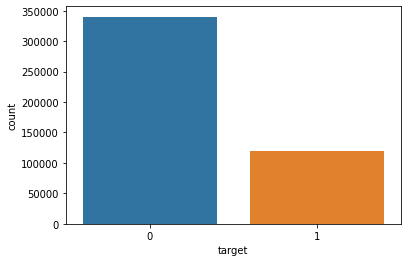

In [17]:
sns.countplot(x = 'target', data = train_dataset)

# Visualizing categorial features

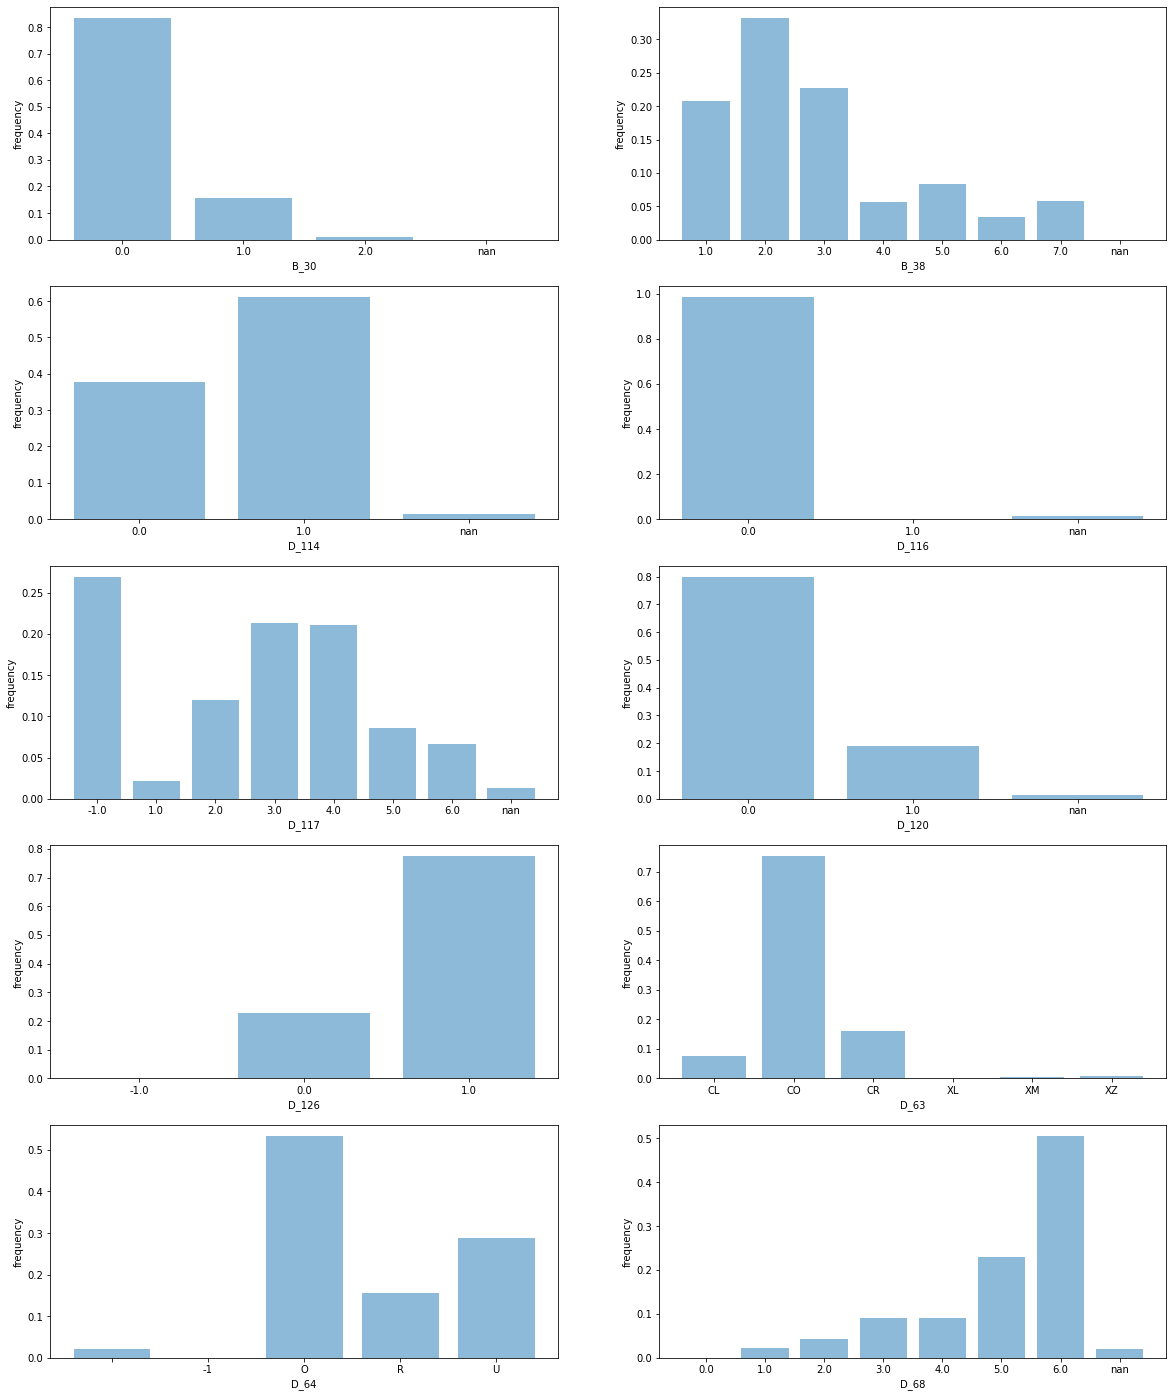

In [18]:
plt.figure(figsize=(20, 30))
for i, k in enumerate(categorical_cols):
    plt.subplot(6, 2, i+1)
    temp_val = pd.DataFrame(train_dataset[k].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
    temp_val.index.name = 'value'
    temp_val.reset_index(inplace=True)
    plt.bar(temp_val.index, temp_val['count'], alpha=0.5)
    plt.xlabel(k)
    plt.ylabel('frequency')
    plt.xticks(temp_val.index, temp_val.value)
plt.show()

# Visualizing categorial features based on the target

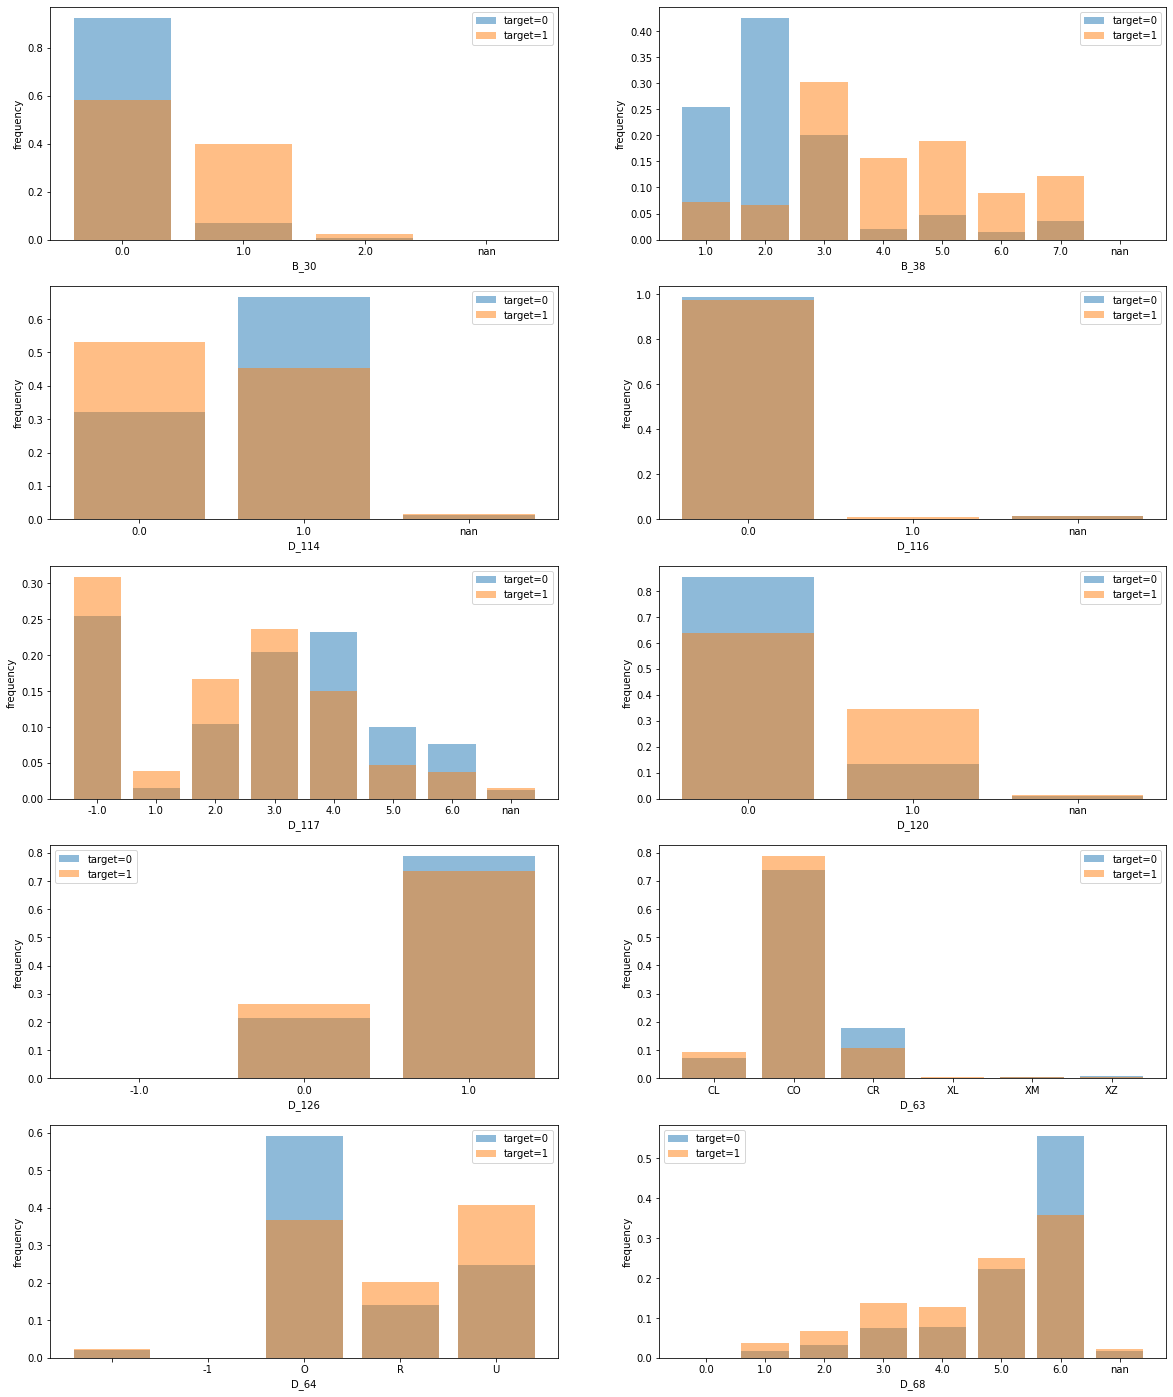

In [19]:
plt.figure(figsize=(20, 30))
for i, f in enumerate(categorical_cols):
    plt.subplot(6, 2, i+1)
    temp = pd.DataFrame(train_dataset[f][train_dataset.target == 0].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
    temp.index.name = 'value'
    temp.reset_index(inplace=True)
    plt.bar(temp.index, temp['count'], alpha=0.5, label='target=0')
    temp = pd.DataFrame(train_dataset[f][train_dataset.target == 1].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
    temp.index.name = 'value'
    temp.reset_index(inplace=True)
    plt.bar(temp.index, temp['count'], alpha=0.5, label='target=1')
    plt.xlabel(f)
    plt.ylabel('frequency')
    plt.legend()
    plt.xticks(temp.index, temp.value)
plt.show()

# Visualizing continuous features

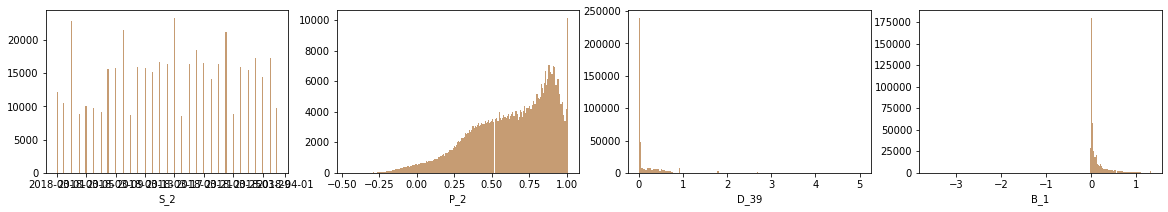

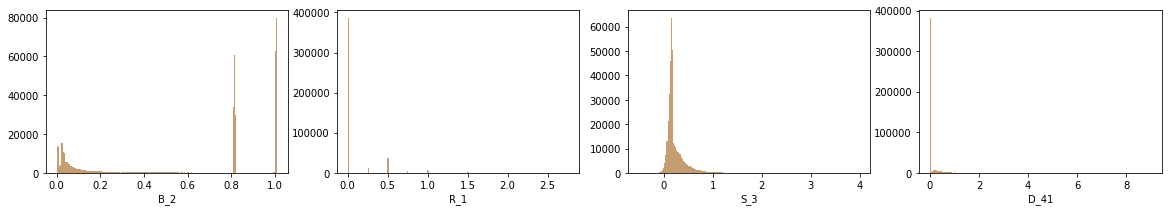

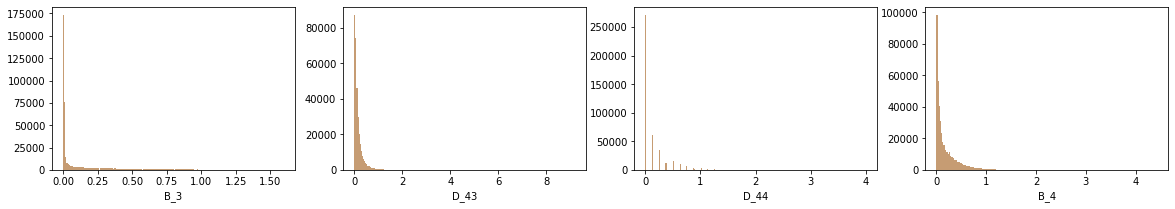

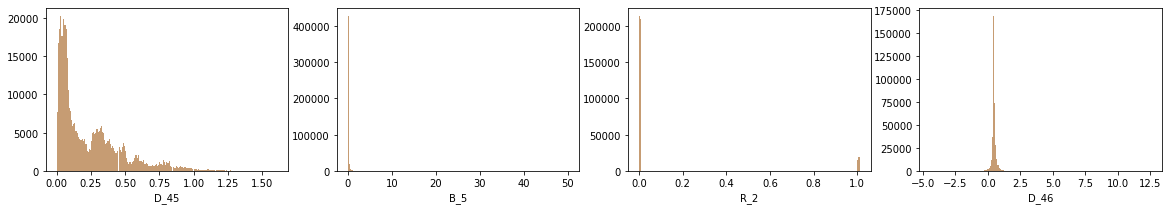

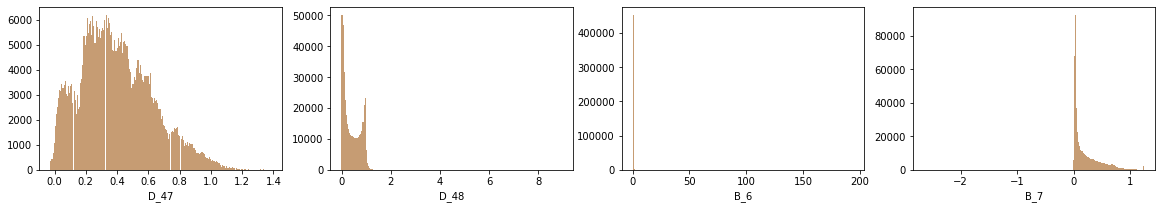

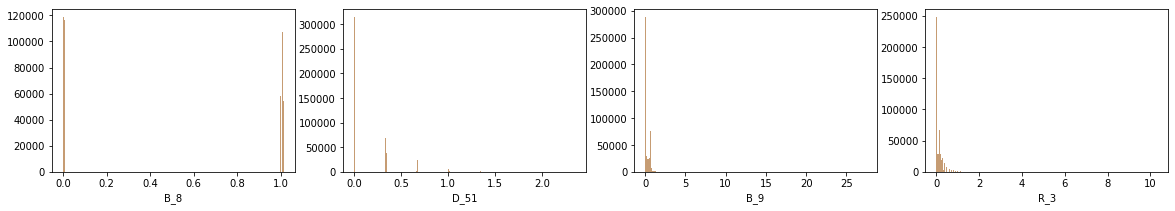

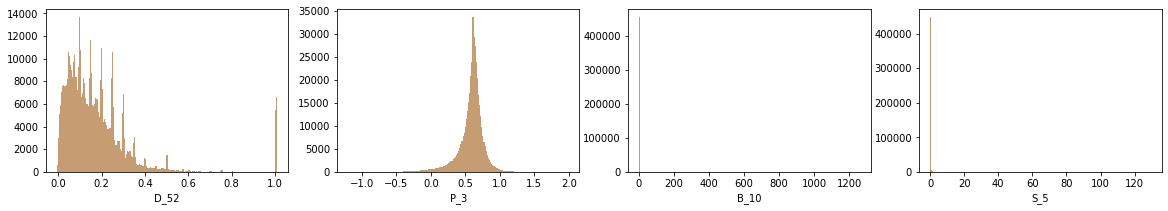

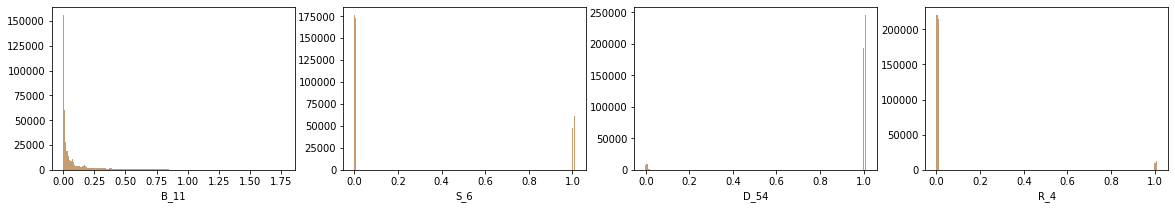

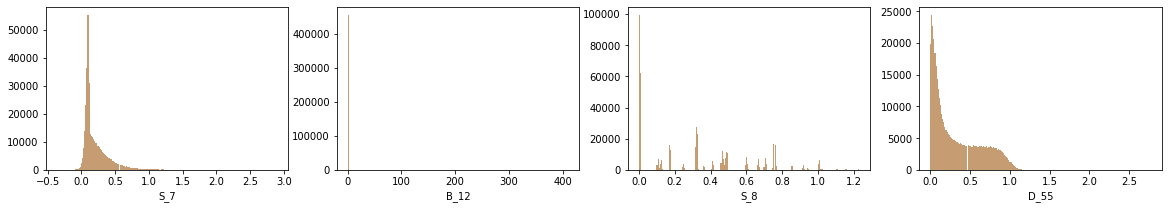

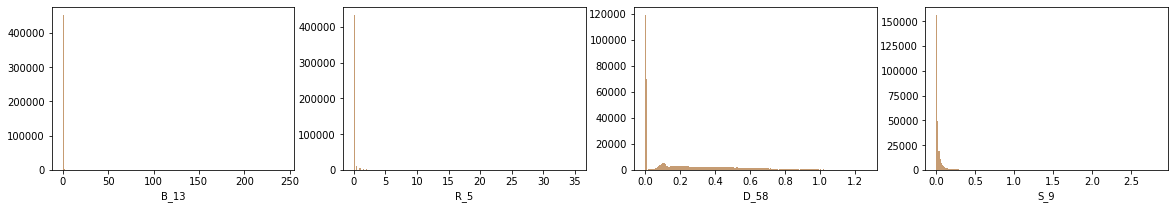

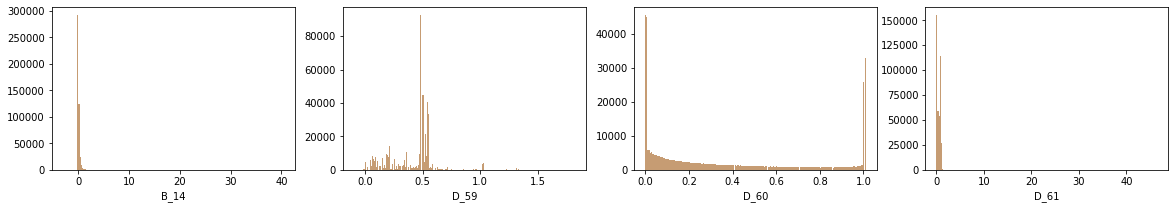

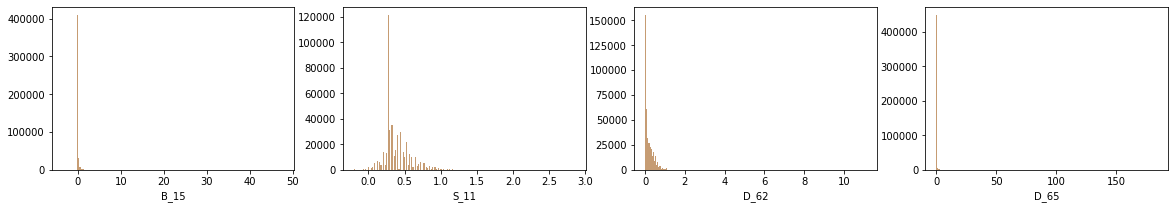

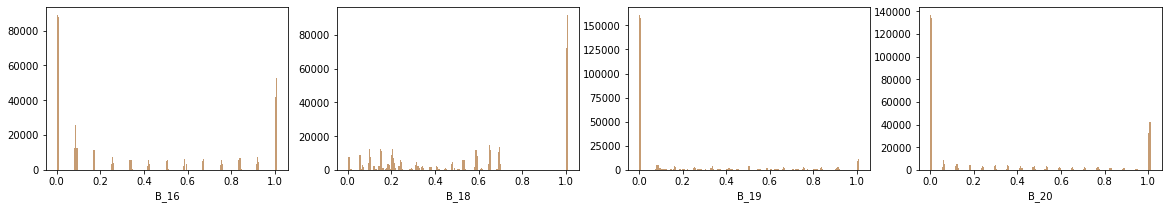

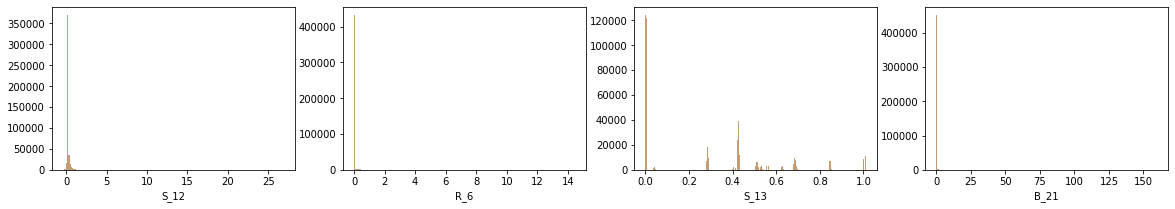

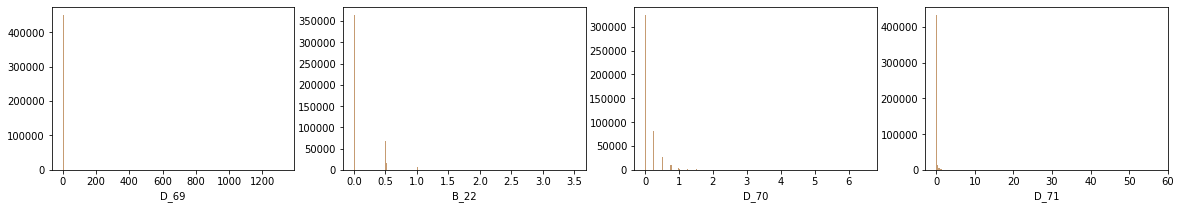

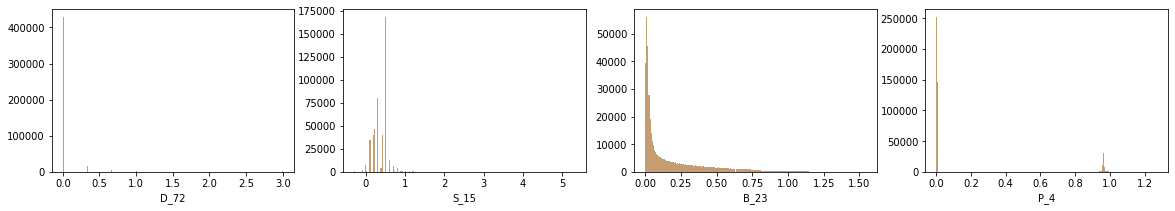

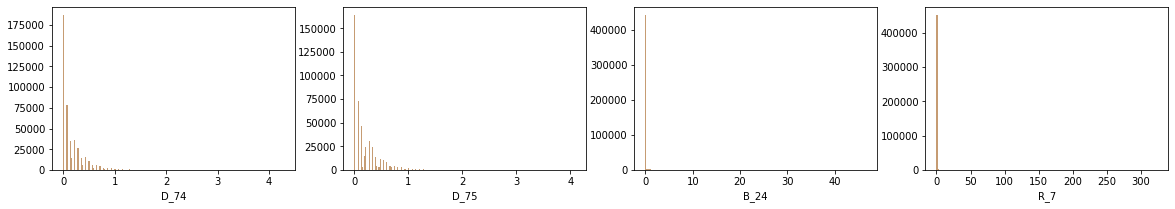

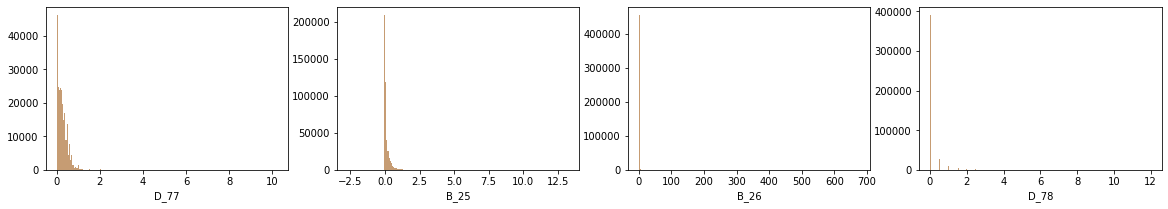

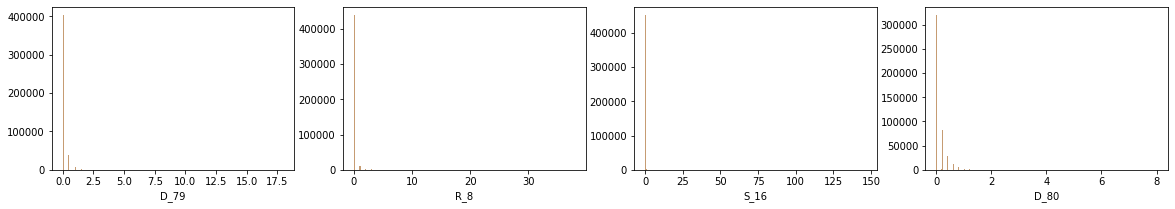

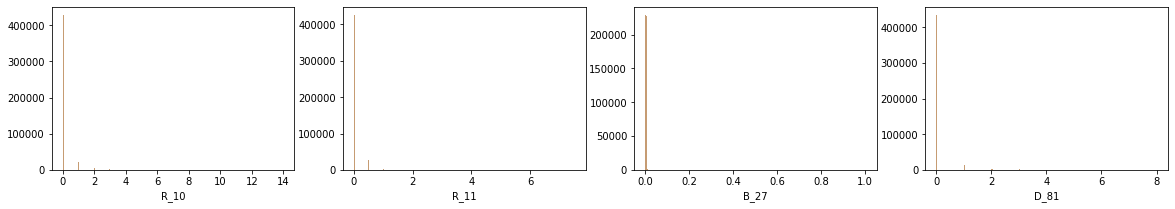

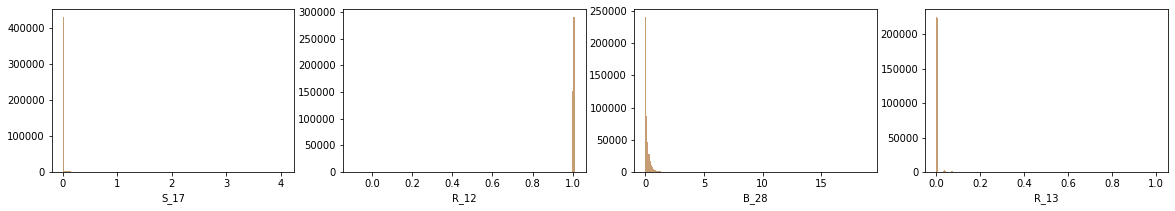

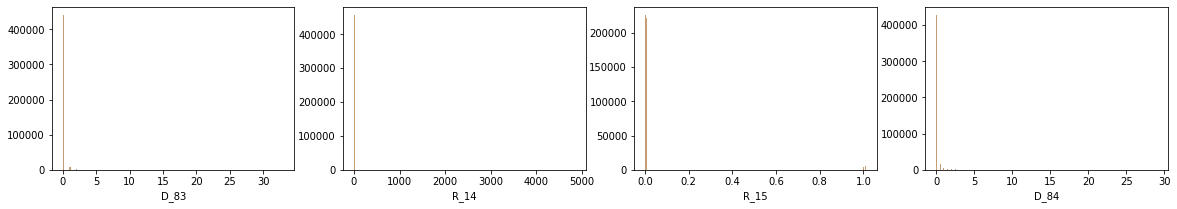

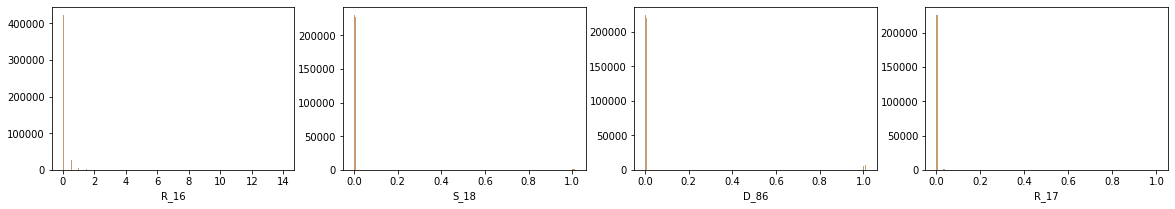

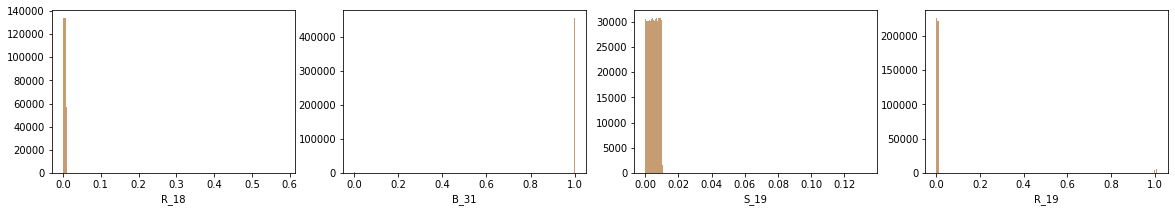

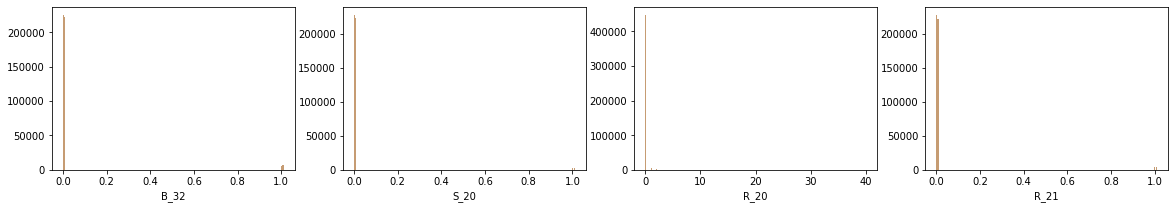

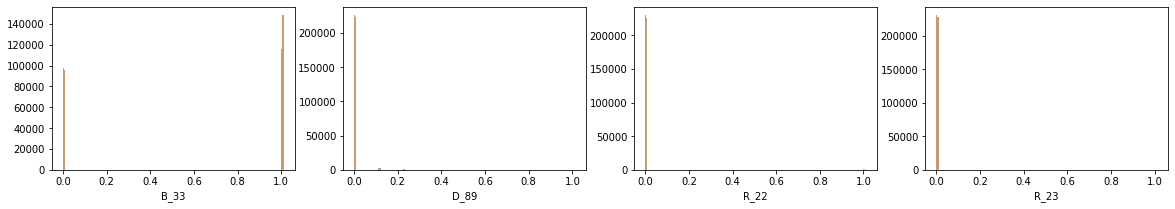

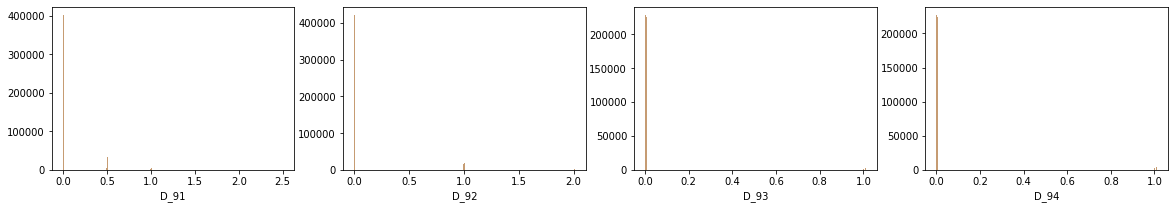

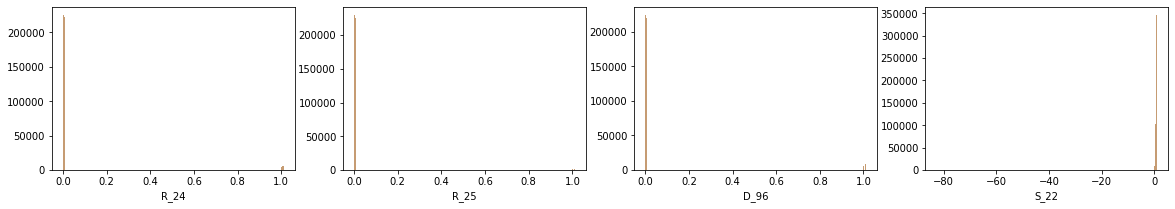

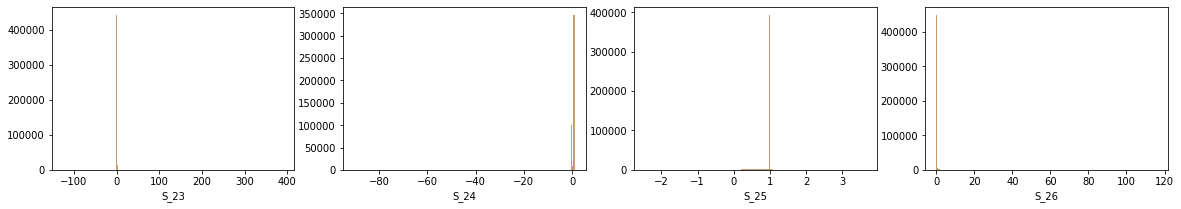

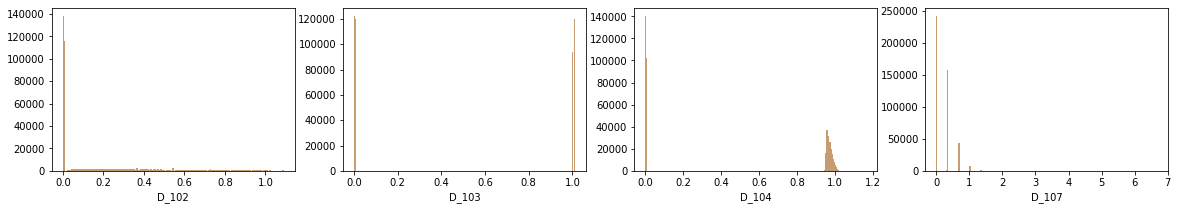

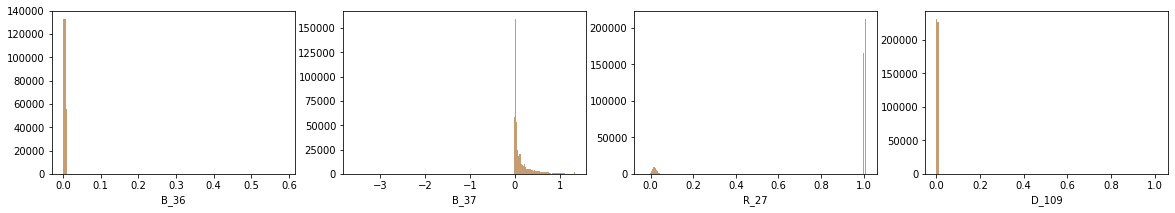

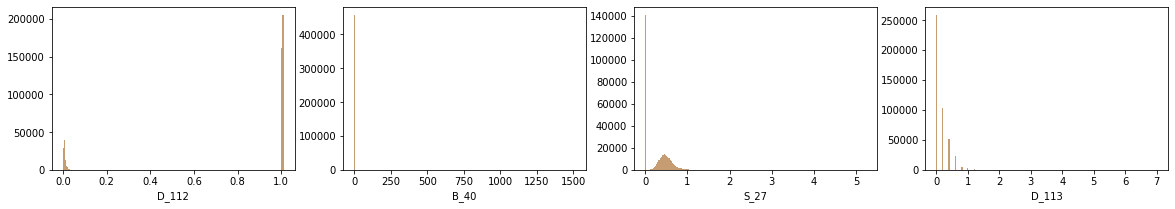

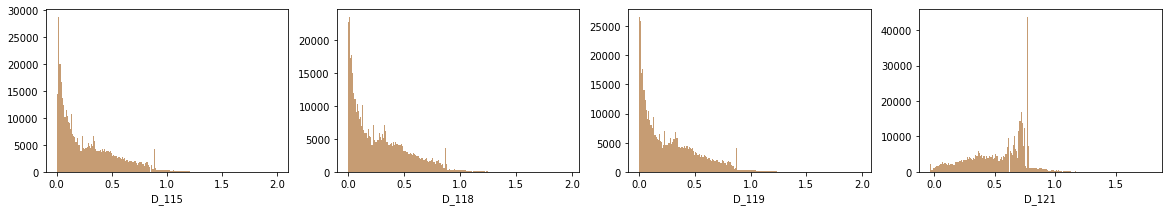

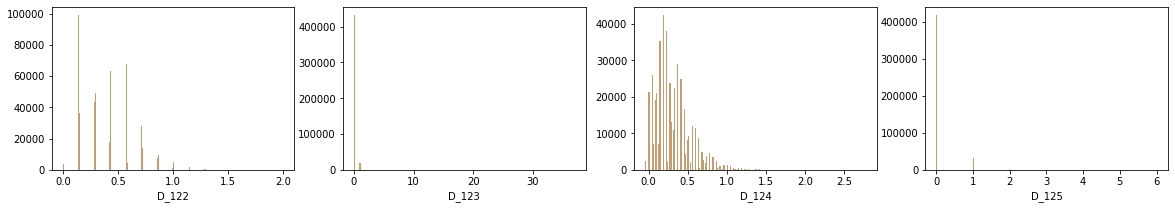

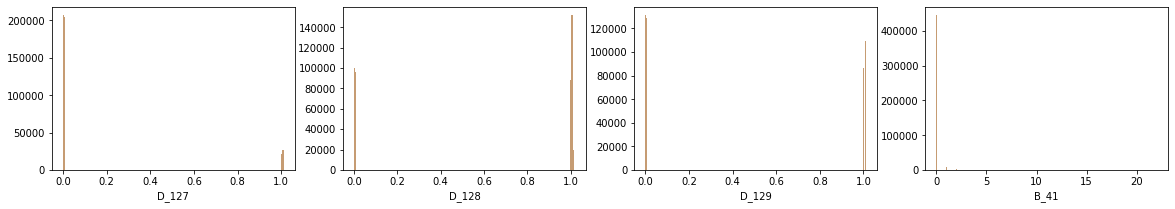

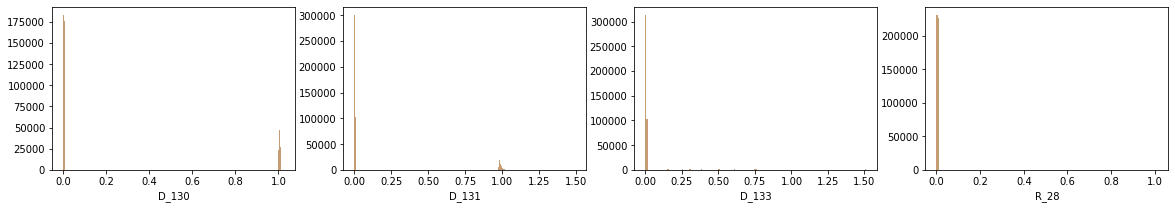

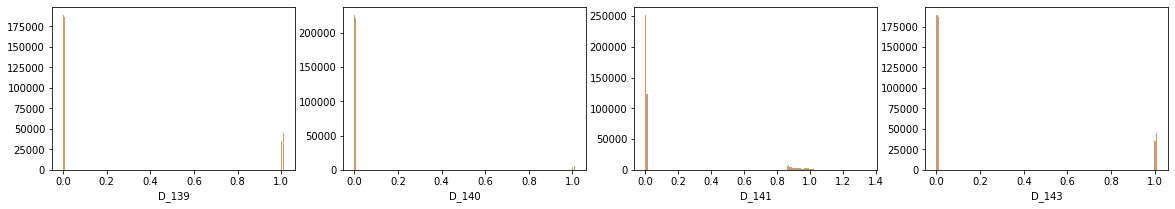

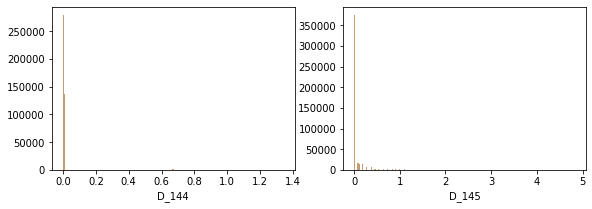

In [20]:
for i, l in enumerate(num_cols):
    if i % 4 == 0: 
        if i > 0: plt.show()
        plt.figure(figsize=(20, 3))
    plt.subplot(1, 4, i % 4 + 1)
    plt.hist(train_dataset[l], bins=200, color='#C69C73')
    plt.xlabel(l)
plt.show()

# Aggregated profile features

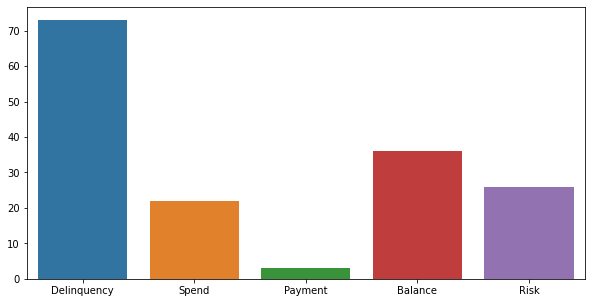

In [21]:
Delinquency = [d for d in train_dataset.columns if d.startswith('D_')]
Spend = [s for s in train_dataset.columns if s.startswith('S_')]
Payment = [p for p in train_dataset.columns if p.startswith('P_')]
Balance = [b for b in train_dataset.columns if b.startswith('B_')]
Risk = [r for r in train_dataset.columns if r.startswith('R_')]
Dict = {'Delinquency': len(Delinquency), 'Spend': len(Spend), 'Payment': len(Payment), 'Balance': len(Balance), 'Risk': len(Risk),}

plt.figure(figsize=(10,5))
sns.barplot(x=list(Dict.keys()), y=list(Dict.values()));

# Fill null values

In [22]:
selected_col = ['P_2','S_3','B_2','D_41','D_43','B_3','D_44','D_45','D_46','D_48','D_50','D_53','S_7','D_56','S_9','B_6','B_8','D_52','P_3','D_54','D_55','B_13','D_59','D_61','B_15','D_62','B_16','B_17','D_77','B_19','B_20','D_69','B_22','D_70','D_72','D_74','R_7','B_25','B_26','D_78','D_79','D_80','B_27','D_81','R_12','D_82','D_105','S_27','D_83','R_14','D_84','D_86','R_20','B_33','D_89','D_91','S_22','S_23','S_24','S_25','S_26','D_102','D_103','D_104','D_107','B_37','R_27','D_109','D_112','B_40','D_113','D_115','D_118','D_119','D_121','D_122','D_123','D_124','D_125','D_128','D_129','B_41','D_130','D_131','D_133','D_139','D_140','D_141','D_143','D_144','D_145']

for f in columns_to_drop:
    if f in selected_col:
        selected_col.remove(f)
        
        
selected_col = np.array(selected_col)

for col in selected_col:
    train_dataset[col] = train_dataset[col].fillna(train_dataset[col].median())

In describe session you saw, lot of cloumns means are NaN. So, that's why i have used median to fill NaN values. 

In [23]:
selected_col2 = ['D_68','B_30','B_38','D_64','D_114','D_116','D_117','D_120','D_126']

for f in columns_to_drop:
    if f in selected_col2:
        selected_col2.remove(f)
        
selcted_col2 = np.array(selected_col2)

for col2 in selcted_col2:
    train_dataset[col2] =  train_dataset[col2].fillna(train_dataset[col2].mode()[0])

# Check again null values

In [24]:
print(train_dataset.isnull().sum().to_string())

S_2       0
P_2       0
D_39      0
B_1       0
B_2       0
R_1       0
S_3       0
D_41      0
B_3       0
D_43      0
D_44      0
B_4       0
D_45      0
B_5       0
R_2       0
D_46      0
D_47      0
D_48      0
B_6       0
B_7       0
B_8       0
D_51      0
B_9       0
R_3       0
D_52      0
P_3       0
B_10      0
S_5       0
B_11      0
S_6       0
D_54      0
R_4       0
S_7       0
B_12      0
S_8       0
D_55      0
B_13      0
R_5       0
D_58      0
S_9       0
B_14      0
D_59      0
D_60      0
D_61      0
B_15      0
S_11      0
D_62      0
D_63      0
D_64      0
D_65      0
B_16      0
B_18      0
B_19      0
B_20      0
D_68      0
S_12      0
R_6       0
S_13      0
B_21      0
D_69      0
B_22      0
D_70      0
D_71      0
D_72      0
S_15      0
B_23      0
P_4       0
D_74      0
D_75      0
B_24      0
R_7       0
D_77      0
B_25      0
B_26      0
D_78      0
D_79      0
R_8       0
S_16      0
D_80      0
R_10      0
R_11      0
B_27      0
D_81      0
S_17

There are no more missing values

In [25]:
train_dataset.shape

(458913, 161)

In [26]:
train_dataset.head()

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_43,...,D_131,D_133,R_28,D_139,D_140,D_141,D_143,D_144,D_145,target
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,2018-03-13,0.934570,0.009117,0.009384,1.007812,0.006104,0.135010,0.001604,0.007175,0.092407,...,0.005703,0.006210,0.002716,0.007187,0.004234,0.005085,0.005810,0.002970,0.008530,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,2018-03-25,0.880371,0.178101,0.034698,1.003906,0.006912,0.165527,0.005550,0.005070,0.060638,...,0.001928,0.002996,0.001701,0.002981,0.007481,0.007874,0.003284,0.003170,0.008514,0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,2018-03-12,0.880859,0.009705,0.004284,0.812500,0.006451,0.164917,0.003796,0.007195,0.092407,...,0.003469,0.009880,0.007690,0.007381,0.006622,0.000965,0.002201,0.000834,0.003445,0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,2018-03-29,0.621582,0.001082,0.012566,1.005859,0.007828,0.287842,0.004532,0.009941,0.046112,...,0.004578,0.001789,0.005138,0.002705,0.006184,0.001899,0.008186,0.005558,0.002983,0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,2018-03-30,0.872070,0.005573,0.007679,0.815918,0.001247,0.164917,0.000231,0.005527,0.044678,...,0.008896,0.005047,0.003706,0.002974,0.004162,0.005764,0.008156,0.006943,0.000905,0


# Load Testing DataSet

In [27]:
test_dataset_ = pd.read_feather('../input/amexfeather/test_data.ftr')
# Keep the latest statement features for each customer
test_dataset = test_dataset_.groupby('customer_ID').tail(1).set_index('customer_ID', drop=True).sort_index()

In [28]:
del test_dataset_
gc.collect()

32408

In [29]:
test_dataset.head()

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
customer_ID,,,,,,,,,,,,,,,,,,,,,
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,2019-10-12,0.568848,0.121399,0.010780,1.009766,0.006924,0.149414,0.000396,0.003576,0.10376,...,NaN,NaN,NaN,0.005913,0.001250,0.006542,NaN,0.009163,0.003691,0.003220
00001bf2e77ff879fab36aa4fac689b9ba411dae63ae397d4263dafa1daedef5,2019-04-15,0.841309,0.126465,0.016556,1.008789,0.009712,0.112183,0.006191,0.011383,NaN,...,NaN,NaN,NaN,0.004345,0.000866,0.009117,NaN,0.002197,0.000247,0.007778
0000210045da4f81e5f122c6bde5c2a617d03eef67f82c5e400fc98e7bd43ce8,2019-10-16,0.697754,0.002724,0.001485,0.810059,0.002621,0.166138,0.004887,0.015945,NaN,...,NaN,NaN,NaN,1.000977,0.008896,0.895996,0.150146,1.009766,0.457764,0.092041
00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976cf6e56734528702d694,2019-04-22,0.513184,0.324707,0.149536,0.205688,0.002277,0.181152,0.005814,0.498535,NaN,...,NaN,NaN,NaN,1.007812,0.003754,0.919922,0.255371,1.007812,0.500977,0.182983
00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9a4693dd914fca22557,2019-10-22,0.254395,0.768066,0.563477,0.038025,0.502930,0.168335,0.009483,0.831055,NaN,...,NaN,NaN,NaN,0.006622,0.001140,0.009529,NaN,0.009407,0.001557,0.000525


In [30]:
test_dataset.shape

(924621, 189)

# Check null values

In [31]:
NaN_Val2 = np.array(test_dataset.isnull().sum())
NaN_prec2 = np.array((test_dataset.isnull().sum() * 100 / len(test_dataset)).round(2))
NaN_Col2 = pd.DataFrame([np.array(list(test_dataset.columns)).T,NaN_Val2.T,NaN_prec2.T,np.array(list(test_dataset.dtypes)).T], index=['Features','Num of Missing values','Percentage','DataType']
).transpose()
pd.set_option('display.max_rows', None)

NaN_Col2

,Features,Num of Missing values,Percentage,DataType
0,S_2,0,0.0,datetime64[ns]
1,P_2,4784,0.52,float16
2,D_39,0,0.0,float16
3,B_1,0,0.0,float16
4,B_2,43,0.0,float16
5,R_1,0,0.0,float16
6,S_3,144280,15.6,float16
7,D_41,43,0.0,float16
8,B_3,43,0.0,float16
9,D_42,827578,89.5,float16


# Drop unuseful columns

In [32]:
test_dataset = test_dataset.drop(['S_2','D_42','D_49','D_66','D_73','D_76','R_9','B_29','D_87','D_88','D_106','R_26','D_108','D_110','D_111','B_39','B_42','D_132','D_134','D_135','D_136','D_137','D_138','D_142'], axis=1)

# Fill null values

In [33]:
selected_column = np.array(['P_2','S_3','B_2','D_41','D_43','B_3','D_44','D_45','D_46','D_48','D_50','D_53','S_7','D_56','S_9','S_12','S_17','B_6','B_8','D_52','P_3','D_54','D_55','B_13','D_59','D_61','B_15','D_62','B_16','B_17','D_77','B_19','B_20','D_69','B_22','D_70','D_72','D_74','R_7','B_25','B_26','D_78','D_79','D_80','B_27','D_81','R_12','D_82','D_105','S_27','D_83','R_14','D_84','D_86','R_20','B_33','D_89','D_91','S_22','S_23','S_24','S_25','S_26','D_102','D_103','D_104','D_107','B_37','R_27','D_109','D_112','B_40','D_113','D_115','D_118','D_119','D_121','D_122','D_123','D_124','D_125','D_128','D_129','B_41','D_130','D_131','D_133','D_139','D_140','D_141','D_143','D_144','D_145'])

for column in selected_column:
    test_dataset[column] = test_dataset[column].fillna(test_dataset[column].median())

In [34]:
selected_column2 = np.array(['D_68','B_30','B_38','D_114','D_116','D_117','D_120','D_126'])

for column2 in selected_column2:
    test_dataset[column2] =  test_dataset[column2].fillna(test_dataset[column2].mode()[0])

# Check again null values

In [35]:
print(test_dataset.isnull().sum().to_string())

P_2      0
D_39     0
B_1      0
B_2      0
R_1      0
S_3      0
D_41     0
B_3      0
D_43     0
D_44     0
B_4      0
D_45     0
B_5      0
R_2      0
D_46     0
D_47     0
D_48     0
B_6      0
B_7      0
B_8      0
D_50     0
D_51     0
B_9      0
R_3      0
D_52     0
P_3      0
B_10     0
D_53     0
S_5      0
B_11     0
S_6      0
D_54     0
R_4      0
S_7      0
B_12     0
S_8      0
D_55     0
D_56     0
B_13     0
R_5      0
D_58     0
S_9      0
B_14     0
D_59     0
D_60     0
D_61     0
B_15     0
S_11     0
D_62     0
D_63     0
D_64     0
D_65     0
B_16     0
B_17     0
B_18     0
B_19     0
B_20     0
D_68     0
S_12     0
R_6      0
S_13     0
B_21     0
D_69     0
B_22     0
D_70     0
D_71     0
D_72     0
S_15     0
B_23     0
P_4      0
D_74     0
D_75     0
B_24     0
R_7      0
D_77     0
B_25     0
B_26     0
D_78     0
D_79     0
R_8      0
S_16     0
D_80     0
R_10     0
R_11     0
B_27     0
D_81     0
D_82     0
S_17     0
R_12     0
B_28     0
R_13     0

In [36]:
test_dataset.shape

(924621, 165)

In [37]:
test_dataset.head()

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_43,D_44,...,D_130,D_131,D_133,R_28,D_139,D_140,D_141,D_143,D_144,D_145
customer_ID,,,,,,,,,,,,,,,,,,,,,
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,0.568848,0.121399,0.010780,1.009766,0.006924,0.149414,0.000396,0.003576,0.007397,0.006786,...,0.004902,0.000975,0.006271,0.008820,0.005913,0.001250,0.006542,0.009163,0.003691,0.003220
00001bf2e77ff879fab36aa4fac689b9ba411dae63ae397d4263dafa1daedef5,0.841309,0.126465,0.016556,1.008789,0.009712,0.112183,0.006191,0.011383,0.096863,0.004234,...,0.001252,0.007633,0.002768,0.008789,0.004345,0.000866,0.009117,0.002197,0.000247,0.007778
0000210045da4f81e5f122c6bde5c2a617d03eef67f82c5e400fc98e7bd43ce8,0.697754,0.002724,0.001485,0.810059,0.002621,0.166138,0.004887,0.015945,0.105286,0.003382,...,1.003906,0.001152,0.002045,0.001852,1.000977,0.008896,0.895996,1.009766,0.457764,0.092041
00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976cf6e56734528702d694,0.513184,0.324707,0.149536,0.205688,0.002277,0.181152,0.005814,0.498535,0.211670,0.258545,...,0.009438,0.002775,0.009377,0.003622,1.007812,0.003754,0.919922,1.007812,0.500977,0.182983
00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9a4693dd914fca22557,0.254395,0.768066,0.563477,0.038025,0.502930,0.168335,0.009483,0.831055,0.071899,0.375732,...,0.003340,0.001000,0.007942,0.009232,0.006622,0.001140,0.009529,0.009407,0.001557,0.000525


# Encode categorical variable With Oridinal encoders

In [38]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
if "D_66" in categorical_cols:
    categorical_cols.remove('D_66')
if "S_2" in categorical_cols:
    categorical_cols.remove('S_2')

train_dataset[categorical_cols] = enc.fit_transform(train_dataset[categorical_cols])
test_dataset[categorical_cols] = enc.transform(test_dataset[categorical_cols])

# Remove highly correlated features

Remove columns if there are > 90% of correlations

In [39]:
train_dataset_without_target = train_dataset.drop(["target"],axis=1)

cor_matrix = train_dataset_without_target.corr()
col_core = set()

for i in range(len(cor_matrix.columns)):
    for j in range(i):
        if(cor_matrix.iloc[i, j] > 0.9):
            col_name = cor_matrix.columns[i]
            col_core.add(col_name)
col_core

{'B_11',
 'B_13',
 'B_15',
 'B_23',
 'B_33',
 'B_37',
 'D_104',
 'D_119',
 'D_141',
 'D_143',
 'D_74',
 'D_75',
 'D_77',
 'S_24',
 'S_7'}

In [40]:
train_dataset = train_dataset.drop(col_core, axis=1)
test_dataset = test_dataset.drop(col_core, axis=1)

In [41]:
train_dataset.shape

(458913, 146)

# Feature Engineering

In [42]:
num_columns = [col for col in train_dataset.columns if col not in ["target","S_2"]]

X = train_dataset[num_columns]
y = train_dataset['target']

print(f"X shape is = {X.shape}" )
print(f"Y shape is = {y.shape}" )

X shape is = (458913, 144)
Y shape is = (458913,)


### Scaling

In [43]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()

In [44]:
X_columns = X.columns
X = scale.fit_transform(X)

In [45]:
X = pd.DataFrame(X,columns= X_columns)

### PCA

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from copy import deepcopy as dc

In [47]:
X_pca=dc(X)
X_pca_test = test_dataset[num_columns]
# X_test_df = test_dataset
# X_temp = X_df.values
# sc = StandardScaler()
# X_std = sc.fit_transform(X_temp)

pca = PCA(n_components=0.9)
X_pca = pca.fit_transform(X_pca)
X_pca_test=pca.transform(X_pca_test)
print(pca.n_components_)

88


In [48]:
X_pca.shape

(458913, 88)

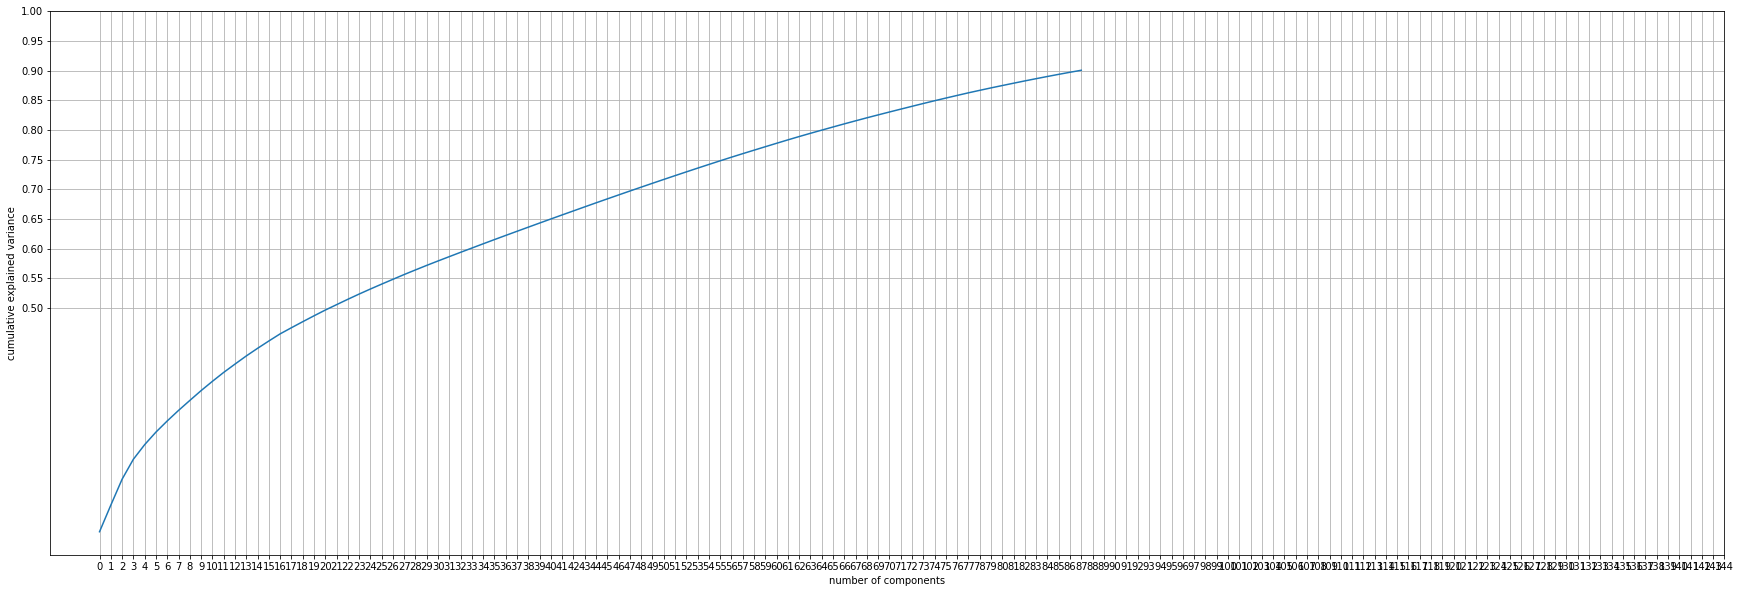

In [49]:
plt.figure(figsize=(30, 10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xticks(np.arange(0, X.shape[1]+1, 1.0))
plt.yticks(np.arange(0.5, 1.05, 0.05))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid()
plt.show()

# Train Model

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

x_train,x_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train shape is = {x_train.shape}" )
print(f"Y_train shape is = {y_train.shape}" )
print(f"X_test shape is = {x_test.shape}" )
print(f"Y_test shape is = {y_test.shape}" )

X_train shape is = (367130, 144)
Y_train shape is = (367130,)
X_test shape is = (91783, 144)
Y_test shape is = (91783,)


## LightGBM

In [51]:
import lightgbm as lgb

d_train = lgb.Dataset(x_train, label=y_train, categorical_feature = categorical_cols)

params = {'objective': 'binary','n_estimators': 1200,'metric': 'binary_logloss','boosting': 'gbdt','num_leaves': 90,'reg_lambda' : 50,'colsample_bytree': 0.19,'learning_rate': 0.03,'min_child_samples': 2400,'max_bins': 511,'seed': 42,'verbose': -1}

# trained model with 100 iterations
model_lgb = lgb.train(params, d_train, 100)

#### Evaluation

In [52]:
predictions_acc_eval = model_lgb.predict(x_test[num_columns])
# # predictions

In [53]:
roc=roc_auc_score(y_test,predictions_acc_eval)
print(f"roc_score={roc}")

### Write out result

In [54]:
lgbm_final_pred = model_lgb.predict(test_dataset[num_columns])

In [55]:
sample_dataset = pd.read_csv('/kaggle/input/amex-default-prediction/sample_submission.csv')
lgbm_output = pd.DataFrame({'customer_ID': sample_dataset.customer_ID, 'prediction': lgbm_final_pred})
lgbm_output.to_csv('lgbm_submission.csv', index=False)

## KNN

In [56]:
# test train split for PCA
x_pca_train,x_pca_test,y_train,y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

In [57]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier(n_neighbors = 5)
model_knn.fit(x_pca_train, y_train)

In [58]:
y_pred_knn=model_knn.predict(x_pca_test)

#### Evaluation

In [59]:
predictions_acc_eval = model_knn.predict(x_pca_test)

In [60]:
roc=roc_auc_score(y_test,predictions_acc_eval)
print(f"roc_score={roc}")

### Write out result

In [61]:
knn_final_pred = model_knn.predict(X_pca_test)

In [62]:
sample_dataset = pd.read_csv('/kaggle/input/amex-default-prediction/sample_submission.csv')
knn_output = pd.DataFrame({'customer_ID': sample_dataset.customer_ID, 'prediction': knn_final_pred})
knn_output.to_csv('knn_submission.csv', index=False)

## SVM

In [ ]:
from sklearn import svm

model_svm = svm.SVC(kernel='rbf', random_state = 1)

model_svm.fit(x_train, y_train)

In [ ]:
y_pred_svm = model_svm.predict(x_test)

In [ ]:
acc_svm=accuracy_score(y_test, y_pred_svm)
roc_svm=roc_auc_score(y_test,y_pred_svm)
f1_svm=f1_score(y_test, y_pred_svm, average='macro')
print(f"accuracy_score={acc_svm}")
print(f"roc_score={roc_svm}")
print(f"f1_score={f1_svm}")

#### Write out

In [ ]:
svm_final_pred = model_svm.predict(test_dataset[num_columns])

In [ ]:
sample_dataset = pd.read_csv('/kaggle/input/amex-default-prediction/sample_submission.csv')
svm_output = pd.DataFrame({'customer_ID': sample_dataset.customer_ID, 'prediction': svm_final_pred})
svm_output.to_csv('svm_submission.csv', index=False)

# Apparently the best model

# Make Prediction

In [ ]:
# predictions = best_model.predict(test_dataset[num_columns])
# predictions

# Output

In [ ]:
# sample_dataset = pd.read_csv('/kaggle/input/amex-default-prediction/sample_submission.csv')
# output = pd.DataFrame({'customer_ID': sample_dataset.customer_ID, 'prediction': predictions})
# output.to_csv('submission.csv', index=False)

In [ ]:
# output.head()